In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import random 
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid
import numpy as np
import ast
from datetime import datetime, timedelta
import math



C:\Users\denni\AppData\Local\Temp\ipykernel_14316\3272212771.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:

class PVOutputAPI:
    BASE_URL = "https://pvoutput.org/service/r2/getstatus.jsp"
    
    def __init__(self, api_key, system_id):
        self.api_key = api_key
        self.system_id = system_id

    def get_status(self, date=None, time=None, history=None, ascending=None, limit=None, time_from=None, time_to=None, extended_data=None, another_system_id=None, day_statistics=None):
        params = {
            'd': date,
            't': time,
            'h': history,
            'asc': ascending,
            'limit': limit,
            'from': time_from,
            'to': time_to,
            'ext': extended_data,
            'sid1': another_system_id,
            'stats': day_statistics
        }
        
        headers = {
            'X-Pvoutput-Apikey': self.api_key,
            'X-Pvoutput-SystemId': self.system_id
        }

        response = requests.get(self.BASE_URL, headers=headers, params=params)
        
        if response.status_code == 200:
            return response.text  
        else:
            response.raise_for_status()

# Example usage
if __name__ == "__main__":
    api_key = "a6fde136a0f43555bfe0beff83520a1cb9a49c57"
    system_id = "105034"
    
    pv_output_api = PVOutputAPI(api_key, system_id)
    
    # Example: Get status with specific parameters
    response = pv_output_api.get_status(date="20230531", ascending="1", history="1", time_from="00:00", limit="500", time_to="23:55", extended_data="1", another_system_id="23471")
    print(response)

def parse_response_to_dataframe(response):
    # Split the response string into individual entries
    entries = response.split(';')
    
    # Extract the first 4 fields from each entry
    data = []
    for entry in entries:
        # Skip any empty strings
        fields = entry.split(',')[:5]
        data.append(fields)
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=['Date', 'Time', 'Energy generation (kWh)', 'Efficiency', 'Power generation (W)'])
    return df

# Parse the response and convert it to a DataFrame
df = parse_response_to_dataframe(response)
print(df)



20230531,06:05,0,0.000,0,NaN,NaN,NaN,NaN,23.5,223.3,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:10,3,0.001,36,36,0.012,NaN,NaN,24.0,223.0,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:15,7,0.002,48,48,0.015,NaN,NaN,25.4,223.1,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:20,13,0.004,72,72,0.023,NaN,NaN,26.4,223.4,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:25,19,0.006,72,72,0.023,NaN,NaN,27.0,223.7,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:30,28,0.009,108,108,0.035,NaN,NaN,27.5,224.2,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:35,37,0.012,108,108,0.035,NaN,NaN,27.8,223.2,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:40,49,0.016,144,144,0.046,NaN,NaN,28.1,222.7,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:45,62,0.020,156,156,0.050,NaN,NaN,28.4,223.3,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:50,78,0.025,192,192,0.062,NaN,NaN,28.5,223.8,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:55,94,0.030,192,192,0.062,NaN,NaN,28.8,223.5,NaN,NaN,NaN,NaN,NaN,NaN;20230531,07:00,114,0.037,240,240,0.077,NaN,NaN,29.0,223.4,NaN,NaN,NaN,NaN,NaN,NaN;20230531,07:05,136,0.044,264,264,0.085,NaN

In [3]:
# Combine Date and Time into a single DateTime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Set DateTime as the index
df.set_index('DateTime', inplace=True)

# Create a complete time range for the day at 5-minute intervals
full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')

# Create a complete DataFrame with zero values
full_day_df = pd.DataFrame(index=full_day)
full_day_df['Energy generation (kWh)'] = 0
full_day_df['Efficiency'] = 0.000
full_day_df['Power generation (W)'] = 0

# Merge the complete DataFrame with the existing data
merged_df = full_day_df.merge(df, how='left', left_index=True, right_index=True, suffixes=('', '_y'))

# Fill missing values with zero
merged_df['Energy generation (kWh)'] = merged_df['Energy generation (kWh)_y'].fillna(0)
merged_df['Efficiency'] = merged_df['Efficiency_y'].fillna(0.000)
merged_df['Power generation (W)'] = merged_df['Power generation (W)_y'].fillna(0)

# Drop the duplicate columns
merged_df = merged_df[['Energy generation (kWh)', 'Efficiency', 'Power generation (W)']]

# Filter out rows that are not exact hour values
merged_df = merged_df[merged_df.index.minute == 0]


# Reset index to have DateTime as a column
merged_df.reset_index(inplace=True)


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1563371316.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


In [4]:

values = merged_df['Energy generation (kWh)'].tolist()


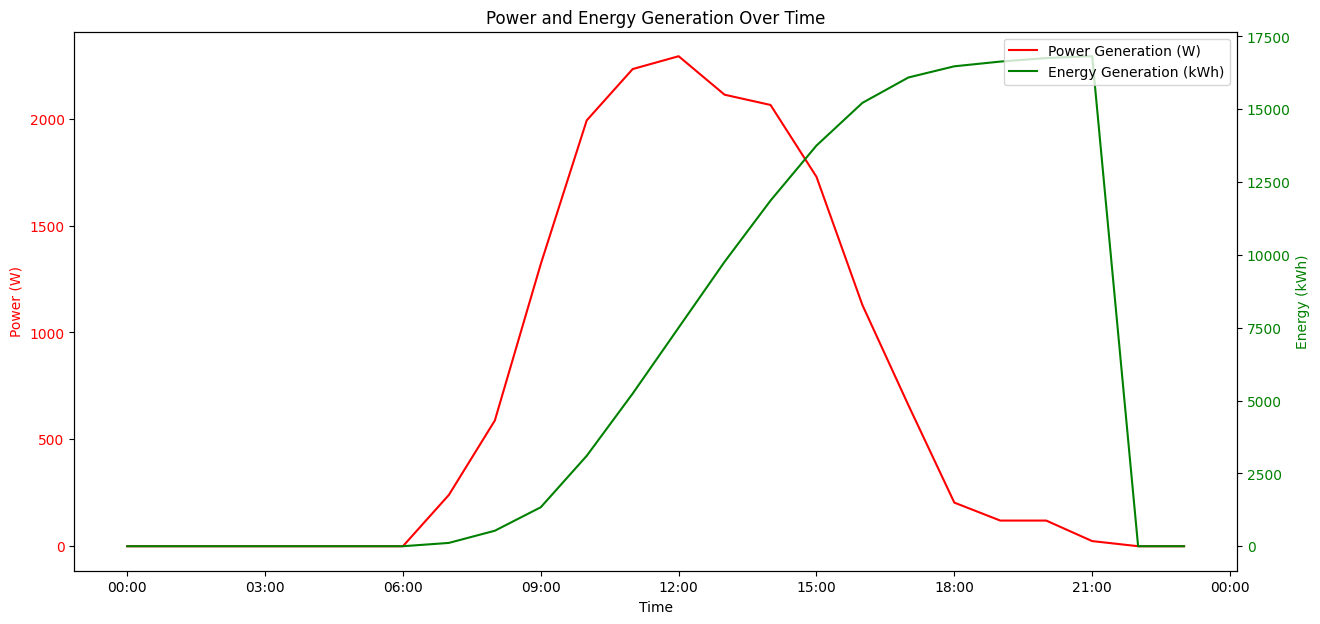

In [5]:
df = merged_df.copy()
# Convert 'index' column to datetime
df['index'] = pd.to_datetime(df['index'])

# Plotting
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot Power Generation
ax1.plot(df['index'], df['Power generation (W)'], 'r-', label='Power Generation (W)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Power (W)', color='r')
ax1.tick_params(axis='y', labelcolor='r')
#ax1.set_ylim(0, 5000)  # Scale y-axis to 5000W

# Create a secondary y-axis for Energy Generation
ax2 = ax1.twinx()
ax2.plot(df['index'], df['Energy generation (kWh)'], 'g-', label='Energy Generation (kWh)')
ax2.set_ylabel('Energy (kWh)', color='g')
ax2.tick_params(axis='y', labelcolor='g')
#ax2.set_ylim(0, 20)  # Scale y-axis to 20 kWh

# Adding a legend
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Formatting the x-axis to show time only
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

# Adding a title
plt.title('Power and Energy Generation Over Time')

# Display the plot
plt.show()

In [6]:
class PVOutputAPI:
    BASE_URL = "https://pvoutput.org/service/r2/getstatus.jsp"
    
    def __init__(self, api_key, system_id):
        self.api_key = api_key
        self.system_id = system_id

    def get_status(self, date=None, time=None, history=None, ascending=None, limit=None, time_from=None, time_to=None, extended_data=None, another_system_id=None, day_statistics=None):
        params = {
            'd': date,
            't': time,
            'h': history,
            'asc': ascending,
            'limit': limit,
            'from': time_from,
            'to': time_to,
            'ext': extended_data,
            'sid1': another_system_id,
            'stats': day_statistics
        }
        
        headers = {
            'X-Pvoutput-Apikey': self.api_key,
            'X-Pvoutput-SystemId': self.system_id
        }

        response = requests.get(self.BASE_URL, headers=headers, params=params)
        
        if response.status_code == 200:
            return response.text
        else:
            response.raise_for_status()

def parse_response_to_dataframe(response):
    entries = response.split(';')
    data = []
    for entry in entries:
        fields = entry.split(',')[:5]
        data.append(fields)
    
    df = pd.DataFrame(data, columns=['Date', 'Time', 'Energy generation (kWh)', 'Efficiency', 'Power generation (W)'])
    return df

def process_data_for_date(api, date,another_system_id):
    response = api.get_status(date=date, ascending="1", history="1", time_from="00:00", limit="500", time_to="23:55", extended_data="1", another_system_id=another_system_id)
    df = parse_response_to_dataframe(response)
    
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df.set_index('DateTime', inplace=True)
    
    full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')
    full_day_df = pd.DataFrame(index=full_day)
    full_day_df['Energy generation (kWh)'] = 0
    full_day_df['Efficiency'] = 0.000
    full_day_df['Power generation (W)'] = 0
    
    merged_df = full_day_df.merge(df, how='left', left_index=True, right_index=True, suffixes=('', '_y'))
    
    merged_df['Energy generation (kWh)'] = merged_df['Energy generation (kWh)_y'].fillna(0)
    merged_df['Efficiency'] = merged_df['Efficiency_y'].fillna(0.000)
    merged_df['Power generation (W)'] = merged_df['Power generation (W)_y'].fillna(0)
    
    merged_df = merged_df[['Energy generation (kWh)', 'Efficiency', 'Power generation (W)']]
    merged_df = merged_df[merged_df.index.minute == 0]
    merged_df.reset_index(inplace=True)
    
    return merged_df

api_key = "a6fde136a0f43555bfe0beff83520a1cb9a49c57"
system_id = "105034"
another_system_id = "83018"
pv_output_api = PVOutputAPI(api_key, system_id)

# Generate 10 random start dates
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 21)
random_dates = [start_date + timedelta(days=random.randint(0, (end_date - start_date).days)) for _ in range(10)]

all_data = []

# Collect data for each randomly selected start date and the subsequent 9 days
for start in random_dates:
    for offset in range(10):
        current_date = start + timedelta(days=offset)
        date_str = current_date.strftime("%Y%m%d")
        try:
            daily_data = process_data_for_date(pv_output_api, date_str,another_system_id)
            values = daily_data['Power generation (W)'].tolist()
            # Replace NaN values with 0 in the values list
            values = [0 if math.isnan(int(x)) else int(x) for x in values]
            
            all_data.append({'Date': date_str, 'Values': values,'system_id':system_id})
        except Exception as e:
            print(f"Error processing date {date_str}: {e}")

final_df = pd.DataFrame(all_data)
print(final_df)
final_df.to_csv(f'measurement_data/energy_measurement_data_{another_system_id}.csv', index=False)



C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230718: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230719: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230720: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230721: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230722: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230723: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230724: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230725: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230726: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230727: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230810: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230811: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230812: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230813: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230814: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230815: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230816: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230817: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230818: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230819: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231122: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231123: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231124: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231125: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231126: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231127: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231128: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231129: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231130: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231201: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231003: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231004: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231005: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231006: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231007: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231008: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231009: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231010: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231011: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231012: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231102: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231103: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231104: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231105: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231106: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231107: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231108: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231109: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231110: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231111: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230325: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230326: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230327: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230328: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230329: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230330: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230331: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230401: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230402: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230403: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231129: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231130: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231201: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231202: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231203: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231204: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231205: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231206: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231207: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231208: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231110: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231111: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231112: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231113: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231114: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231115: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231116: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231117: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231118: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20231119: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230920: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230921: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230922: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230923: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230924: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230925: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230926: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230927: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230928: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230929: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230201: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230202: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230203: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230204: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230205: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230206: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230207: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230208: invalid literal for int() with base 10: 'NaN'


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


Error processing date 20230209: invalid literal for int() with base 10: 'NaN'
Error processing date 20230210: invalid literal for int() with base 10: 'NaN'
Empty DataFrame
Columns: []
Index: []


C:\Users\denni\AppData\Local\Temp\ipykernel_14316\1144893452.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


In [8]:
# Define the Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Function to fit Gaussian to daily data
def fit_gaussian_to_daily_data(hourly_data):
    x_numeric = np.arange(len(hourly_data))
    try:
        # Initial guesses: amplitude, center, and width
        p0 = [max(hourly_data), np.argmax(hourly_data), 10]
        popt, _ = curve_fit(gaussian, x_numeric, hourly_data, p0=p0, maxfev=1000)
        return popt
    except Exception as e:
        print(f"Error in Gaussian fit: {e}")
        return None

# Convert all elements in the list to integers
def convert_to_integers(data_list):
    return [int(x) if isinstance(x, str) else x for x in data_list]


# Load energy data from CSV
def load_and_process_data(filename):
    df = pd.read_csv(filename)
    results = []
    df_solar_panels = pd.read_csv('solarpanels.csv',sep=';')

    #print(df_system_id['sid'])
    panel_details = df_solar_panels[df_solar_panels['sid'] == int(another_system_id)]
    
    #print(panel_details['orientation']) #.iloc[0]
    print(panel_details)

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        try:
            # Safely convert string representation of list back to list
            energy_data = ast.literal_eval(row['Values'])

            # Convert all elements to integers
            energy_data = convert_to_integers(energy_data)

            #print(energy_data,type(energy_data[15]))
            popt = fit_gaussian_to_daily_data(energy_data)
            if popt is not None:
                # Generate dense x values for plotting or further analysis
                x_dense = np.linspace(0, 23, 500)
                gaussian_curve = gaussian(x_dense, *popt)
                area_gaussian = trapezoid(gaussian_curve, dx=x_dense[1] - x_dense[0])
                area_original = trapezoid(energy_data, dx=1)
                delta_auc = area_original / area_gaussian if area_gaussian != 0 else None
                results.append({
                    'Date': row['Date'],
                    'system_id':another_system_id,
                    'Orientation': panel_details['orientation'].values[0],
                    'Tilt': panel_details['tilt'].values[0],
                    'Panel Type': panel_details['type_panel'].values[0],
                    'Gaussian Parameters': popt,
                    'Delta AUC': delta_auc,
                    'energy_data': energy_data/ (panel_details['npanels'].values[0] * (panel_details['width'].values[0] /1000 )* (panel_details['height'].values[0]/1000)),
                    'energy_data_raw': energy_data,
                })
        except Exception as e:
            print(f"Error processing row {index}: {e}")

    return pd.DataFrame(results)

#print(system_id)
#solarpanels = pd.read_csv('solarpanels.csv',sep=';')
#solarpanels.head()
#solarpanels = solarpanels[solarpanels['sid'] == int(another_system_id)]
#print(solarpanels)
#Assuming the CSV file is in the current directory
filename = f'measurement_data/energy_measurement_data_{another_system_id}.csv'
fitted_results = load_and_process_data(filename)
fitted_results.to_csv(f'measurement_data/fitted_gaussian_results_{another_system_id}.csv', index=False)
fitted_results.head()



EmptyDataError: No columns to parse from file

In [9]:
import os 
import ast

def convert_string_to_list(string):
    return list(map(float, string.strip('[]').replace('\n', '').split()))

directory = 'measurement_data/'

excel_files = [f for f in os.listdir(directory) if f.endswith('.csv') and f.startswith('fitted_gaussian_results_')]

print(excel_files)

dfs = []

# Loop through the list of files
for file in excel_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path) 
    dfs.append(df)

# Concatenate all DataFrames
final_df = pd.concat(dfs, ignore_index=True)

# Apply the function to the 'energy_data' column
final_df['energy_data'] = final_df['energy_data'].apply(convert_string_to_list)

# Save the final DataFrame to a CSV file
final_output_path = 'measurement_data/final_measurement_data2.csv'
final_df.to_csv(final_output_path, index=False)

# Display the head of the DataFrame and the first energy_data entry as a listf
#print(final_df['energy_data'][0])
final_df.head()

['fitted_gaussian_results_13000.csv', 'fitted_gaussian_results_23471.csv', 'fitted_gaussian_results_24499.csv', 'fitted_gaussian_results_28156.csv', 'fitted_gaussian_results_32174.csv', 'fitted_gaussian_results_36256.csv', 'fitted_gaussian_results_43872.csv', 'fitted_gaussian_results_56126.csv', 'fitted_gaussian_results_58815.csv', 'fitted_gaussian_results_67109.csv', 'fitted_gaussian_results_77899.csv', 'fitted_gaussian_results_84071.csv', 'fitted_gaussian_results_88330.csv', 'fitted_gaussian_results_96352.csv']


,Date,system_id,Orientation,Tilt,Panel Type,Gaussian Parameters,Delta AUC,energy_data,energy_data_raw
0,20230122,13000,135,40,monocrystalline,[ 0. 0. 10.],NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,20230124,13000,135,40,monocrystalline,[162.60442768 13.85284896 1.36444051],0.992572,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 27, 57, 140,..."
2,20230125,13000,135,40,monocrystalline,[57.82577091 14.12112444 1.86139873],0.982190,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 22, 38, 37,..."
3,20230126,13000,135,40,monocrystalline,[344.81091461 13.6904891 1.70028957],0.988036,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 118, 167, 3..."
4,20230127,13000,135,40,monocrystalline,[362.09304571 12.74704606 1.79033874],0.959402,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 110, 306, 244, ..."


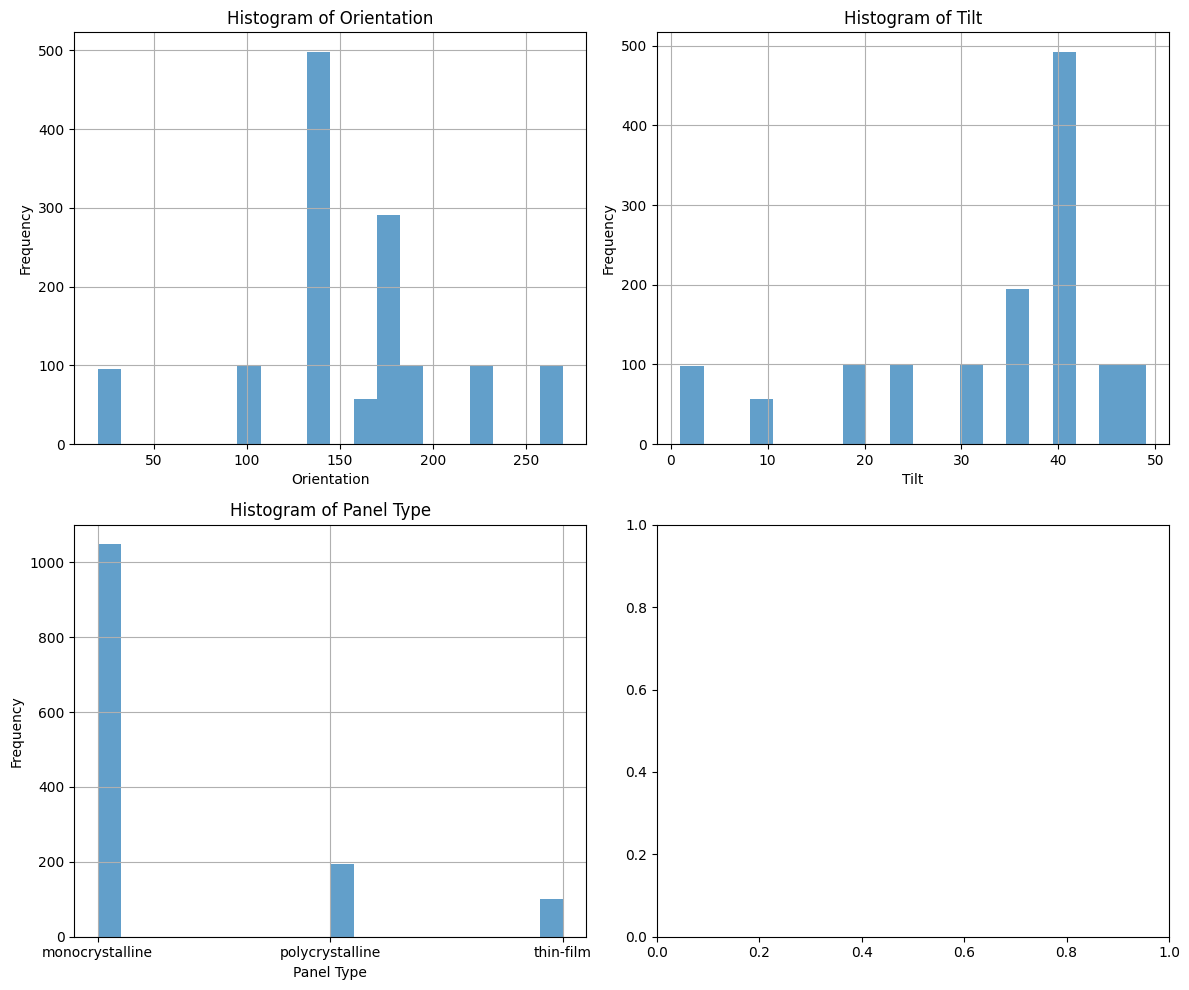

In [10]:
hist_columns = ['Orientation', 'Tilt', 'Panel Type',]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten() 

for i, col in enumerate(hist_columns):
    if col in final_df.columns:
        final_df[col].hist(ax=axes[i], bins=20, alpha=0.7)
        axes[i].set_title(f'Histogram of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
    else:
        axes[i].text(0.5, 0.5, f'{col} not found in DataFrame', fontsize=12, ha='center')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [11]:
# Load the CSV files into DataFrames
df_solar = pd.read_csv('measurement_data/final_measurement_data2.csv')
df_weather = pd.read_csv('measurement_data/historicalweather2023.csv')

# Convert date formats
# Assuming the date in df_solar is an integer or string without separators
df_solar['date'] = pd.to_datetime(df_solar['Date'].astype(str), format='%Y%m%d')

# Ensure the weather DataFrame date is in datetime format
df_weather['date'] = pd.to_datetime(df_weather['date'], format='%Y-%m-%d')

# Merge the DataFrames on the date column
merged_df = pd.merge(df_solar, df_weather, on='date', how='left')

merged_df = merged_df.drop(['date'], axis=1)

new_column_names = {
    'Date': 'day',
    'Orientation': 'azimuth',
    'Tilt': 'tilt',
    'Panel Type': 'module_type',
    'Gaussian Parameters': 'gaussian_params',
    'Delta AUC': 'delta_auc',  
    'energy_data': 'energy_data',
    'temperature_sequence': 'temperature_sequence',
    'wind_speed_sequence': 'wind_speed_sequence',
    'dni_sequence': 'dni_sequence',
    'dhi_sequence': 'dhi_sequence',
    'global_irradiance_sequence': 'global_irradiance_sequence'
}

df_renamed = merged_df.rename(columns=new_column_names)

# Define the new order of the columns, placing 'delta_auc' last
new_order = [
    'day',
    'system_id',
    'delta_auc',
    'module_type',
    'tilt',
    'azimuth',
    'gaussian_params',
    'energy_data',
    'temperature_sequence',
    'wind_speed_sequence',
    'dni_sequence',
    'dhi_sequence',
    'global_irradiance_sequence',
]

# Reorder the columns
df_final = df_renamed[new_order]


# Save the merged DataFrame to a new CSV file
df_final.to_csv('merged_solar_weather_data2.csv', index=False)